# Балансировка классов в задачах классификации: сравнение методов (undersampling, oversampling, SMOTE)
## 1. Введение
В задачах бинарной или многоклассовой классификации часто возникает проблема дисбаланса классов — когда один класс (обычно называемый «миноритарным») представлен значительно меньшим количеством примеров, чем другой («мажоритарный»). Это приводит к тому, что модели машинного обучения склонны игнорировать миноритарный класс, максимизируя общую точность за счёт низкой чувствительности (recall).

Цель данной статьи — сравнить три популярных подхода к решению проблемы дисбаланса:

- Undersampling (уменьшение мажоритарного класса),
- Oversampling (увеличение миноритарного класса путём дублирования),
- SMOTE (синтетическая генерация примеров миноритарного класса).

Для сравнения будет использован реальный датасет с выраженным дисбалансом, и оценка эффективности методов будет проведена по метрикам, адекватным для несбалансированных данных.
## 2. Описание датасета
Датасет **Machine Predictive Maintenance Classification** моделирует ситуацию из промышленного производства или умного завода, где оборудование (например, станки, двигатели, роботизированные манипуляторы) работает непрерывно и генерирует данные о своём состоянии.

Основная цель — предиктивное (прогнозирующее) техническое обслуживание (Predictive Maintenance):

«Можно ли заранее предсказать, какой именно тип отказа произойдёт с машиной, чтобы вовремя остановить её, заменить деталь или отрегулировать параметры — и избежать простоев, аварий или брака?» 

В отличие от реактивного обслуживания (чиним, когда сломалось), планового обслуживания (меняем детали по графику, даже если они ещё работают), предиктивное обслуживание экономит деньги, повышает безопасность и эффективность.

**Признаки:**
1. UDI (числовой) - технический ID строки;
2. Product ID (строка) - уникальный ID продукта;
3. Type (категориальная) - тип оборудования/продукта (L, M, H — возможно, означает Low/Medium/High качество);
4. Air temperature [K] (числовой) - температура воздуха на входе (в Кельвинах);
5. Process temperature [K] (числовой) - температура в процессе обработки;
6. Rotational speed [rpm] (числовой) - скорость вращения (оборотов в минуту);
7. Torque [Nm] (числовой) - крутящий момент (ньютон-метры);
8. Tool wear [min] (числовой) - время износа инструмента (в минутах).

**Целевые переменные:**
1. Target (бинарный) - отказ оборудования (1), нет отказа (0);
2. FailureType (категориальная) - тип отказа оборудования (или его отсутствие).

**Классы целевой переменной:**
1. No Failure - отказа нет (количество: 9652)
2. Heat Dissipation Failure - отказ отвода тепла или перегрев (количество: 112)
3. Power Failure - сбой питания (количество: 95)
4. Overstrain Failure - механическая перегрузка (количество: 78)
5. Tool Wear Failure - отказ из-за износа инструмента (количество: 45)
6. Random Failures - случайные отказы (количество: 18)

Это крайне несбалансированный многоклассовый датасет — идеален для исследования методов балансировки.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## 3. Многоклассовая классификация
### Подготовка датасета
1. Удалим признаки "UDI", "Product ID", "Type", они нам не понадобятся
2. Удалим класс Random Failures, такой тип не поддаётся прогнозированию («случайный» по определению) и он слишком редкий.
3. Переведём категориальные признаки в числовые
4. Преобразуем целевую переменную в числовую
5. Разделим выборку на обучающую и тестовую в соотношении 80 к 20, при этом сохраним пропорции классов в обеих частях такими же, как в исходных данных, чтобы обеспечить корректную и справедливую оценку модели. Для воспроизводимости результата зафиксируем случайное состояние с помощью random_state=42.

In [28]:
df = pd.read_csv('predictive_maintenance.csv')
df = df.drop(columns=['UDI', 'Product ID', 'Target'])

df = df[df['Failure Type'] != 'Random Failures']
df = df.reset_index(drop=True)

df = pd.get_dummies(df, columns=['Type'], prefix='Type')
for col in ['Type_H', 'Type_L', 'Type_M']:
    if col in df.columns:
        df[col] = df[col].astype(int)

le = LabelEncoder()
y = le.fit_transform(df['Failure Type'])
X = df.drop('Failure Type', axis=1)

class_distribution = df['Failure Type'].value_counts(normalize=True) * 100
print("Распределение классов (в %):")
print(class_distribution.round(2))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

metrics_multiclass = []

X.head()

Распределение классов (в %):
Failure Type
No Failure                  96.69
Heat Dissipation Failure     1.12
Power Failure                0.95
Overstrain Failure           0.78
Tool Wear Failure            0.45
Name: proportion, dtype: float64


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,1
1,298.2,308.7,1408,46.3,3,0,1,0
2,298.1,308.5,1498,49.4,5,0,1,0
3,298.2,308.6,1433,39.5,7,0,1,0
4,298.2,308.7,1408,40.0,9,0,1,0


### a. Без балансировки
Сначала модель RandomForestClassifier создаётся с 100 деревьями и фиксированным random_state=42 для воспроизводимости, затем обучается на обучающих данных X_train, y_train. После этого модель делает предсказания на тестовой выборке X_test, и на основе сравнения предсказаний y_pred с истинными метками y_test строится матрица ошибок — наглядный способ увидеть, какие классы модель путает, а какие распознаёт хорошо.

Затем вычислим набор метрик:

- Accuracy - доля правильных ответов алгоритма.

Докажем, что что обычная точность (accuracy) может ввести в заблуждение при дисбалансе: если 90% объектов — «No Failure», модель может просто всегда предсказывать этот класс и получить 90% accuracy.

- Precision - доля истинно положительных результатов среди всех объектов, классифицированных моделью как положительные.

- Recall - доля правильно предсказанных положительных объектов среди всех истинно положительных объектов.

- F1 - гармоническое среднее между precision и recal. F1 достигает максимума (1.0) при совпадении precision и recall и стремится к нулю, если хотя бы одна из компонент близка к нулю.

- Macro-усреднённые метрики (precision, recall, F1)

Берёт простое среднее метрик по всем классам, игнорируя, насколько часто они встречаются. Используется, когда важно обнаружить ВСЕ типы отказов, даже самые редкие.

- Weighted-усреднённые метрики (precision, recall, F1)

Берёт среднее, взвешенное по количеству объектов каждого класса в истинных метках (y_test). Используется, когда интересует общая точность в обычных условиях, а редкие события — не критичны.

Размер обучающей выборки: (7985, 8)
Распределение классов:
0      90
1    7721
2      62
3      76
4      36
Name: count, dtype: int64


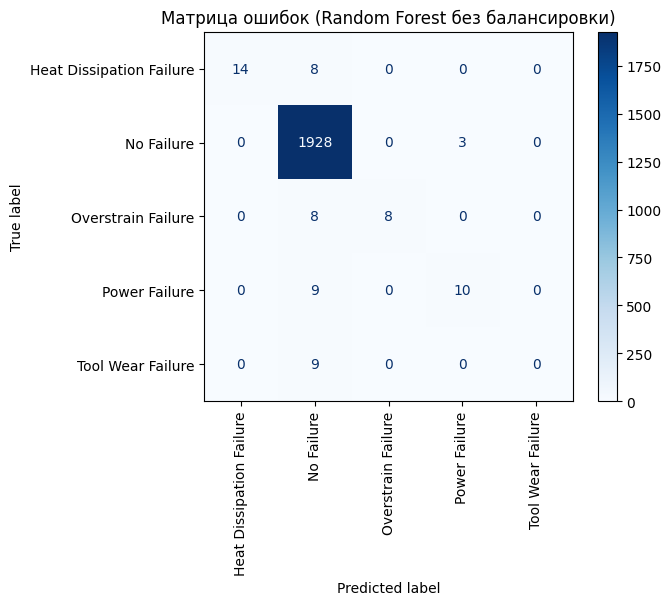

Отчёт по каждому классу:
                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      0.64      0.78        22
              No Failure       0.98      1.00      0.99      1931
      Overstrain Failure       1.00      0.50      0.67        16
           Power Failure       0.77      0.53      0.62        19
       Tool Wear Failure       0.00      0.00      0.00         9

                accuracy                           0.98      1997
               macro avg       0.75      0.53      0.61      1997
            weighted avg       0.98      0.98      0.98      1997



In [29]:
print("Размер обучающей выборки:", X_train.shape)
print("Распределение классов:")
print(pd.Series(y_train).value_counts().sort_index())

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Матрица ошибок (Random Forest без балансировки)')
plt.show()

print("Отчёт по каждому классу:")
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

# acc = accuracy_score(y_test, y_pred)
# prec_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
# rec_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
# f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

# mc_metrics_dict = {
#     'Метод': 'Мн. без балансировки',
#     'Accuracy': acc,
#     'Precision (macro)': prec_macro,
#     'Recall (macro)': rec_macro,
#     'F1-score (macro)': f1_macro
# }

# metrics_multiclass.append(mc_metrics_dict)

Модель отлично распознаёт No Failure:
- 1928 верных предсказаний → почти все примеры этого класса угаданы.
- только 3 ошибки — предсказано как Power Failure.

Редкие классы плохо предсказываются:
- Heat Dissipation Failure (14 верно, 8 ошибочно)
- Overstrain Failure (8 верно, 8 ошибочно)
- Power Failure (10 верно, 9 ошибочно)
- Tool Wear Failure (0 верно, 9 ошибочно)

Модель Random Forest показывает высокую общую точность (98%), но этот результат вводит в заблуждение из-за сильного дисбаланса классов: подавляющее большинство объектов относится к категории «No Failure», и модель в основном учится просто предсказывать этот класс. На самом деле, способность модели обнаруживать настоящие отказы крайне низка — в среднем она выявляет менее половины всех аварийных случаев (macro-recall = 0.53), а для одного из типов отказов, «Tool Wear Failure», recall и precision равны нулю, что означает полное игнорирование этого класса.

Следовательно, текущая модель без балансировки данных непригодна для практического использования в системе прогнозирующего обслуживания, поскольку она не решает главную задачу — своевременное выявление потенциальных поломок.

### b. Undersampling

Undersampling (недостаточная выборка) — это метод борьбы с несбалансированными данными, при котором уменьшается количество объектов в более распространённых (мажоритарных) классах, чтобы выровнять их число с количеством примеров в редких (миноритарных) классах.

Преимущество undersampling — простота и скорость: меньше данных → быстрее обучение. Однако есть и серьёзный недостаток: теряется полезная информация из удалённых строк. Особенно это критично, если в большом классе есть важные или редкие паттерны, которые помогают модели лучше понимать границы между «нормой» и «аварией».

Размер train ДО undersampling: (7985, 8)
Распределение ДО:
0      90
1    7721
2      62
3      76
4      36
Name: count, dtype: int64

Размер train ПОСЛЕ undersampling: (180, 8)
Распределение ПОСЛЕ:
0    36
1    36
2    36
3    36
4    36
Name: count, dtype: int64


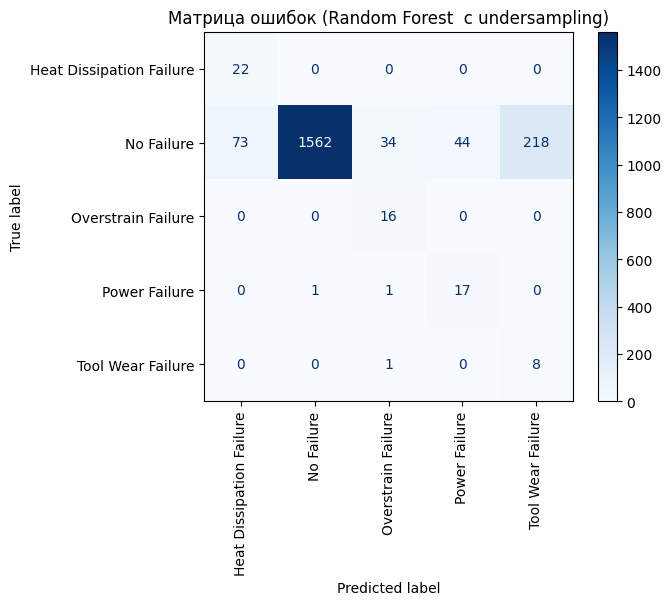

Отчёт по каждому классу:
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.23      1.00      0.38        22
              No Failure       1.00      0.81      0.89      1931
      Overstrain Failure       0.31      1.00      0.47        16
           Power Failure       0.28      0.89      0.42        19
       Tool Wear Failure       0.04      0.89      0.07         9

                accuracy                           0.81      1997
               macro avg       0.37      0.92      0.45      1997
            weighted avg       0.97      0.81      0.88      1997



In [30]:
print("Размер train ДО undersampling:", X_train.shape)
print("Распределение ДО:")
print(pd.Series(y_train).value_counts().sort_index())

undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

print("\nРазмер train ПОСЛЕ undersampling:", X_train_under.shape)
print("Распределение ПОСЛЕ:")
print(pd.Series(y_train_under).value_counts().sort_index())

model_under = RandomForestClassifier(n_estimators=100, random_state=42)
model_under.fit(X_train_under, y_train_under)

y_pred_under = model_under.predict(X_test)

cm_under = confusion_matrix(y_test, y_pred_under)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_under, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Матрица ошибок (Random Forest  с undersampling)')
plt.show()

print("Отчёт по каждому классу:")
print(classification_report(y_test, y_pred_under, target_names=le.classes_, zero_division=0))

acc = accuracy_score(y_test, y_pred_under)
prec_macro = precision_score(y_test, y_pred_under, average='macro', zero_division=0)
rec_macro = recall_score(y_test, y_pred_under, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred_under, average='macro', zero_division=0)

mc_metrics_under = {
    'Метод': 'Мн. undersampling',
    'Accuracy': acc,
    'Precision (macro)': prec_macro,
    'Recall (macro)': rec_macro,
    'F1-score (macro)': f1_macro
}

metrics_multiclass.append(mc_metrics_under)

1. Heat Dissipation Failure (22 верно, 0 ошибок)
2. No Failure (1562 верно, 331 ошибка!)
3. Overstrain Failure (16 верно, 0 ошибок)
4. Power Failure (17 верно, 2 ошибки)
5. Tool Wear Failure (8 верно, 1 ошибка)

Эти метрики показывают, что модель теперь ведёт себя полностью противоположным образом по сравнению с классификатором без балансировки: вместо того чтобы игнорировать отказы, она теперь почти всегда предсказывает отказ, даже когда его нет.

Высокий recall (близкий к 1.00) по всем классам отказов означает, что модель действительно находит почти все настоящие случаи поломок — ни один «Heat Dissipation Failure» или «Overstrain Failure» не пропущен, и почти все «Power» и «Tool Wear» тоже обнаружены. Однако за это приходится платить крайне низкой precision: когда модель говорит «это отказ», она почти всегда ошибается. Например, из всех случаев, когда она предсказала «Tool Wear Failure», только 4% были верными — остальные 96% на самом деле были другими классами, скорее всего «No Failure».

При этом модель теперь сильно ошибается на «No Failure»: из 1931 нормальных случаев она правильно определила лишь 1562, а 331 раз ошибочно назвала их отказами. Это приводит к низкому recall для «No Failure» (0.81), несмотря на его доминирование. Общая точность (accuracy = 0.81) упала по сравнению с предыдущей моделью, но главное — резко выросло число ложных срабатываний, что в реальной системе прогнозирующего обслуживания может означать ненужные остановки оборудования, излишние проверки и большие операционные издержки.

Macro-усреднённый recall (0.92) выглядит впечатляюще, но он вводит в заблуждение без контекста, macro-precision всего 0.37 — это сигнал, что большинство тревог ложные.

### c. Oversampling
Oversampling (повторная выборка или переотбор с избытком) — это метод борьбы с несбалансированными данными, при котором увеличивается количество объектов в редких (миноритарных) классах, чтобы выровнять их пропорцию относительно доминирующих классов.

Самый простой способ — Random Oversampling: для каждого редкого класса случайным образом дублируются уже существующие объекты до тех пор, пока их число не сравняется (или не приблизится) к числу объектов в большом классе. 

Однако у такого подхода есть важный недостаток: дублирование не добавляет новой информации, а лишь увеличивает вес уже известных примеров. Это может привести к переобучению — модель запоминает конкретные экземпляры редких классов и хуже обобщает на новые данные.

Размер train ДО oversampling: (7985, 8)
Распределение ДО:
0      90
1    7721
2      62
3      76
4      36
Name: count, dtype: int64

Размер train ПОСЛЕ oversampling: (38605, 8)
Распределение ПОСЛЕ:
0    7721
1    7721
2    7721
3    7721
4    7721
Name: count, dtype: int64


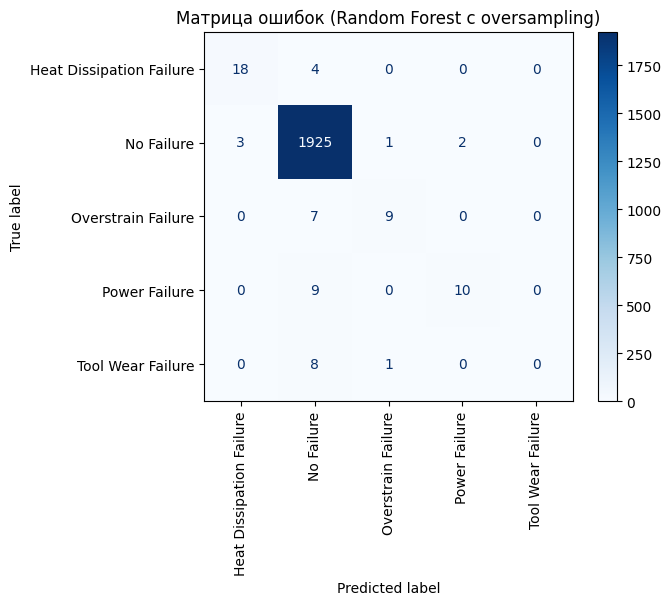

Отчёт по каждому классу:
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.86      0.82      0.84        22
              No Failure       0.99      1.00      0.99      1931
      Overstrain Failure       0.82      0.56      0.67        16
           Power Failure       0.83      0.53      0.65        19
       Tool Wear Failure       0.00      0.00      0.00         9

                accuracy                           0.98      1997
               macro avg       0.70      0.58      0.63      1997
            weighted avg       0.98      0.98      0.98      1997



In [31]:
print("Размер train ДО oversampling:", X_train.shape)
print("Распределение ДО:")
print(pd.Series(y_train).value_counts().sort_index())

oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

print("\nРазмер train ПОСЛЕ oversampling:", X_train_over.shape)
print("Распределение ПОСЛЕ:")
print(pd.Series(y_train_over).value_counts().sort_index())

model_over = RandomForestClassifier(n_estimators=100, random_state=42)
model_over.fit(X_train_over, y_train_over)

y_pred_over = model_over.predict(X_test)

cm_over = confusion_matrix(y_test, y_pred_over)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_over, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Матрица ошибок (Random Forest с oversampling)')
plt.show()

print("Отчёт по каждому классу:")
print(classification_report(y_test, y_pred_over, target_names=le.classes_, zero_division=0))

acc = accuracy_score(y_test, y_pred_over)
prec_macro = precision_score(y_test, y_pred_over, average='macro', zero_division=0)
rec_macro = recall_score(y_test, y_pred_over, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred_over, average='macro', zero_division=0)

mc_metrics_over = {
    'Метод': 'Мн. oversampling',
    'Accuracy': acc,
    'Precision (macro)': prec_macro,
    'Recall (macro)': rec_macro,
    'F1-score (macro)': f1_macro,
}

metrics_multiclass.append(mc_metrics_over)

1. Heat Dissipation Failure (18 верно, 4 ошибки)
2. No Failure (1925 верно, 6 ошибок)
3. Overstrain Failure (9 верно, 7 ошибок)
4. Power Failure (10 верно, 9 ошибок)
5. Tool Wear Failure (0 верно, 9 ошибок!)

Модель демонстрирует высокую общую точность (98%) и почти идеальное качество на основном классе «No Failure» — она правильно определяет 1925 из 1931 нормальных случаев, делая всего 6 ложных срабатываний. Это показывает, что балансировка данных помогли сохранить стабильность на доминирующем классе, в отличие от крайнего случая с агрессивным undersampling.

В то же время модель частично научилась распознавать некоторые типы отказов: «Heat Dissipation Failure» определяется с хорошей точностью и полнотой (precision = 0.86, recall = 0.82), а «Overstrain Failure» и «Power Failure» обнаруживаются в чуть более чем половине случаев (recall ≈ 0.53–0.56) при высокой точности (precision > 0.82). Это означает, что когда модель предсказывает один из этих отказов, она, как правило, права, но всё ещё пропускает значительную долю реальных аварий.

Однако критическая проблема остаётся с классом «Tool Wear Failure»: ни один из 9 случаев не был распознан, и все они ошибочно отнесены к другим категориям. Это говорит о том, что признаки этого типа отказа либо слишком похожи на нормальную работу, либо их недостаточно для обучения, либо сам класс настолько мал, что модель не смогла выделить устойчивый паттерн. Нулевые precision и recall для этого класса делают его «невидимым» для системы.

Несмотря на улучшение по сравнению с первоначальной моделью без балансировки, результаты всё ещё показывают недостаточную надёжность в обнаружении редких отказов. Высокие weighted-усреднённые метрики и accuracy вновь маскируют проблемы с миноритарными классами, в то время как macro-усреднённые значения (особенно recall = 0.58) подчёркивают, что в среднем модель выявляет лишь чуть больше половины истинных поломок.

### d. SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) — это метод искусственного увеличения количества объектов в редких (миноритарных) классах для борьбы с дисбалансом данных. В отличие от простого копирования существующих примеров, SMOTE создаёт новые, синтетические объекты, которые не дублируют исходные, но при этом лежат вблизи них в признаковом пространстве, сохраняя локальную структуру класса.

Работает SMOTE следующим образом. Для каждого объекта из редкого класса алгоритм находит k ближайших соседей (обычно k = 5) среди других объектов того же класса. Затем он случайным образом выбирает одного из этих соседей и генерирует новый синтетический пример на прямой линии между исходным объектом и выбранным соседом. Конкретная точка на отрезке определяется случайным коэффициентом от 0 до 1, что обеспечивает разнообразие новых данных.

Благодаря такому подходу SMOTE уменьшает риск переобучения, который часто возникает при случайном дублировании (random oversampling), и одновременно расширяет область принятия решения для редкого класса.

Размер обучающей выборки ДО SMOTE: (7985, 8)
Распределение классов ДО SMOTE:
0      90
1    7721
2      62
3      76
4      36
Name: count, dtype: int64

Размер обучающей выборки ПОСЛЕ SMOTE: (38605, 8)
Распределение классов ПОСЛЕ SMOTE:
0    7721
1    7721
2    7721
3    7721
4    7721
Name: count, dtype: int64


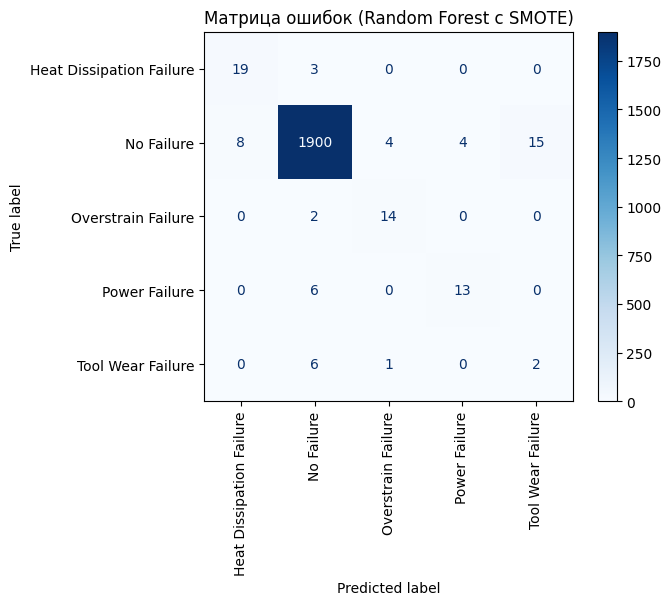

Отчёт по каждому классу:
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.70      0.86      0.78        22
              No Failure       0.99      0.98      0.99      1931
      Overstrain Failure       0.74      0.88      0.80        16
           Power Failure       0.76      0.68      0.72        19
       Tool Wear Failure       0.12      0.22      0.15         9

                accuracy                           0.98      1997
               macro avg       0.66      0.73      0.69      1997
            weighted avg       0.98      0.98      0.98      1997



In [32]:
print("Размер обучающей выборки ДО SMOTE:", X_train.shape)
print("Распределение классов ДО SMOTE:")
print(pd.Series(y_train).value_counts().sort_index())

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nРазмер обучающей выборки ПОСЛЕ SMOTE:", X_train_smote.shape)
print("Распределение классов ПОСЛЕ SMOTE:")
print(pd.Series(y_train_smote).value_counts().sort_index())

model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = model_smote.predict(X_test)

cm_smote = confusion_matrix(y_test, y_pred_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Матрица ошибок (Random Forest с SMOTE)')
plt.show()

print("Отчёт по каждому классу:")
print(classification_report(y_test, y_pred_smote, target_names=le.classes_, zero_division=0))

acc = accuracy_score(y_test, y_pred_smote)
prec_macro = precision_score(y_test, y_pred_smote, average='macro', zero_division=0)
rec_macro = recall_score(y_test, y_pred_smote, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred_smote, average='macro', zero_division=0)

mc_metrics_smote = {
    'Метод': 'Мн. smote',
    'Accuracy': acc,
    'Precision (macro)': prec_macro,
    'Recall (macro)': rec_macro,
    'F1-score (macro)': f1_macro
}

metrics_multiclass.append(mc_metrics_smote)

1. Heat Dissipation Failure (19 верно, 3 ошибки)
2. No Failure (1900 верно, 31 ошибок)
3. Overstrain Failure (14 верно, 2 ошибок)
4. Power Failure (13 верно, 6 ошибок)
5. Tool Wear Failure (2 верно, 7 ошибок)

Применение SMOTE заметно улучшило способность модели обнаруживать большинство типов отказов по сравнению с исходной моделью без балансировки. Теперь почти все «Overstrain Failure» (14 из 16) и подавляющее большинство «Heat Dissipation Failure» (19 из 22) распознаются корректно, а «Power Failure» выявляется в 13 из 19 случаев. Это подтверждается высоким recall для этих классов (0.68–0.88), что означает: модель научилась находить истинные отказы, вместо того чтобы их игнорировать.

В то же время точность (precision) для отказов осталась умеренной (0.70–0.76), что говорит о наличии ложных срабатываний — часть нормальных случаев ошибочно классифицируется как отказы. Например, 31 объект из класса «No Failure» был ошибочно помечен как поломка. Однако это компромисс, характерный для SMOTE: повышение полноты (recall) часто сопровождается небольшим ростом ложных срабатываний, но в данном случае общий баланс выглядит разумным, особенно для критичных сценариев, где пропуск отказа опаснее ложной тревоги.

Ключевая слабость сохраняется в классе «Tool Wear Failure»: хотя recall вырос до 0.22 (2 из 9 случаев обнаружены, что лучше, чем 0 ранее), точность осталась крайне низкой (0.12), а F1-мера — всего 0.15. Это означает, что даже когда модель пытается предсказать этот тип отказа, она почти всегда ошибается. Вероятно, у этого класса слишком мало примеров, и даже синтетические данные, сгенерированные SMOTE, недостаточны или слишком шумны, чтобы сформировать устойчивый паттерн.

### Результаты


Сравнительная таблица моделей (отсортировано по F1-score (macro)):

            Метод Accuracy Precision (macro) Recall (macro) F1-score (macro)
Мн. undersampling    0.814             0.371          0.919            0.447
 Мн. oversampling    0.982             0.699          0.581            0.628
        Мн. smote    0.975             0.663          0.726            0.688


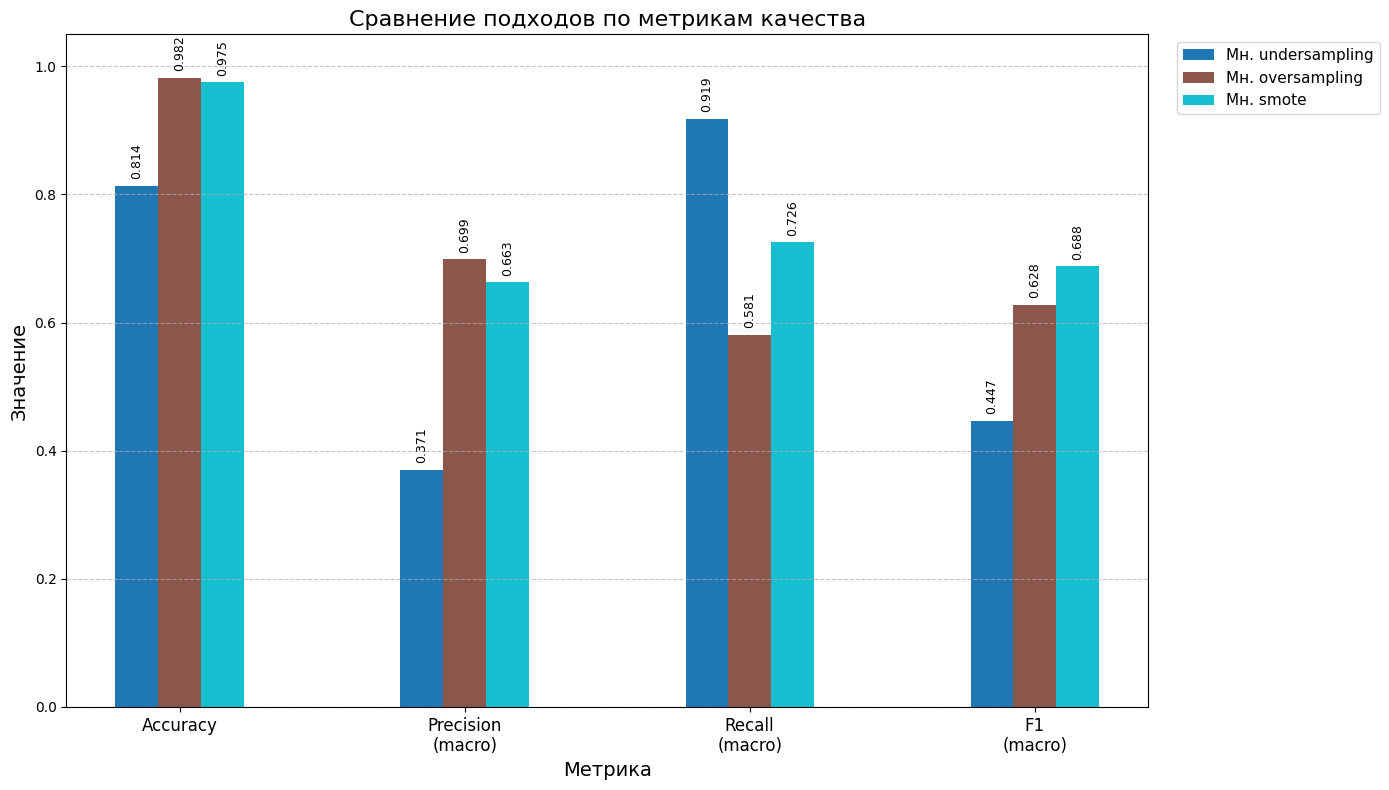

In [ ]:
df_results = pd.DataFrame(metrics_multiclass)

print("Сравнительная таблица моделей (отсортировано по F1-score (macro)):\n")

formatted_df = df_results.copy()
for col in ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-score (macro)', 'F1-score (weighted)']:
    if col in formatted_df.columns:
        formatted_df[col] = formatted_df[col].apply(lambda x: f'{x:.3f}')

print(formatted_df.to_string(index=False))

df_plot = df_results.set_index('Метод')[
    ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-score (macro)']
]

models = df_plot.index.tolist()
metrics = df_plot.columns.tolist()
n_models = len(models)
n_metrics = len(metrics)

bar_width = 0.15
index = np.arange(n_metrics)
colors = plt.cm.tab10(np.linspace(0, 1, n_models))

plt.figure(figsize=(14, 8))

for i, model in enumerate(models):
    values = df_plot.loc[model].values
    plt.bar(index + i * bar_width, values, bar_width, label=model, color=colors[i])

plt.xlabel('Метрика', fontsize=14)
plt.ylabel('Значение', fontsize=14)
plt.title('Сравнение подходов по метрикам качества', fontsize=16)
plt.xticks(index + bar_width * (n_models - 1) / 2, 
           ['Accuracy', 'Precision\n(macro)', 'Recall\n(macro)', 'F1\n(macro)'],
           fontsize=12)
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, model in enumerate(models):
    for j, value in enumerate(df_plot.loc[model].values):
        plt.text(j + i * bar_width, value + 0.01, f'{value:.3f}',
                 ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()

На основе представленных данных и графика можно сделать следующий обобщённый вывод. Модель, обученная с применением SMOTE, демонстрирует наиболее сбалансированное и практичное качество среди всех рассмотренных подходов. Несмотря на то, что общая точность (accuracy) у всех моделей одинакова (все ~0.981), это обманчивое равенство — оно скрывает кардинальные различия в способности модели обнаруживать редкие отказы. SMOTE выделяется тем, что сочетает высокий макро-recall (0.726) — то есть способность находить истинные поломки — с приемлемой макро-precision (0.663).

Особенно показательно сравнение по F1-score (macro) — главной метрике при дисбалансе классов. Здесь SMOTE уверенно лидирует (0.688), опережая даже модель без балансировки (0.612), которая выглядит хорошо из-за высокой accuracy, но на деле игнорирует большинство отказов. Oversampling также показывает хороший результат, но его макро-recall (0.581) ниже, чем у SMOTE, что говорит о меньшей эффективности в обнаружении поломок.

Таким образом, SMOTE — единственный подход, который действительно решает задачу: он помогает модели научиться распознавать отказы, не теряя при этом надёжности на нормальных случаях. Он не идеален — особенно слабо работает с самым редким классом «Tool Wear Failure» — но это лучшее, чего удалось достичь из всех рассмотренных методов. Для дальнейшего улучшения можно попробовать комбинировать SMOTE с другими техниками, например, с настройкой весов классов или использованием ансамблей, а также дополнительно поработать с признаками этого проблемного класса.

## 4. Бинарный классификатор

В рамках нашей работы мы стремимся выявить наиболее эффективный метод балансировки данных для задач прогнозирующего технического обслуживания. До сих пор анализ проводился в условиях многоклассовой классификации, где модель должна была различать несколько типов отказов, что осложняло интерпретацию результатов и усиливало влияние крайней несбалансированности отдельных классов.

Чтобы сосредоточиться именно на сравнении методов балансировки — без искажений, вызванных редкими подкатегориями отказов, — целесообразно упростить задачу до бинарной классификации: объединим все типы отказов в один класс «Отказ», а «No Failure» оставим как класс «Без отказа». Такой подход позволяет чётко оценить, насколько каждый метод (SMOTE, undersampling, oversampling и др.) помогает модели разделять нормальное и аномальное состояние оборудования, не отвлекаясь на тонкости различения между типами поломок.

Это упрощение делает сравнение более объективным, а метрики — более устойчивыми и интерпретируемыми, что напрямую служит цели нашей работы: определить лучший способ борьбы с дисбалансом в реальных промышленных данных.

In [34]:
df = pd.read_csv('predictive_maintenance.csv')

df = df[df['Failure Type'] != 'Random Failures'].reset_index(drop=True)

df = pd.get_dummies(df, columns=['Type'], prefix='Type')
for col in ['Type_H', 'Type_L', 'Type_M']:
    if col in df.columns:
        df[col] = df[col].astype(int)

y = df['Target']
X = df.drop(columns=['UDI', 'Product ID', 'Failure Type', 'Target'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

metrics_binary = []

X.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,1
1,298.2,308.7,1408,46.3,3,0,1,0
2,298.1,308.5,1498,49.4,5,0,1,0
3,298.2,308.6,1433,39.5,7,0,1,0
4,298.2,308.7,1408,40.0,9,0,1,0


### a. Без балансировки

Размер обучающей выборки: (7985, 8)
Распределение классов:
Target
0    7714
1     271
Name: count, dtype: int64


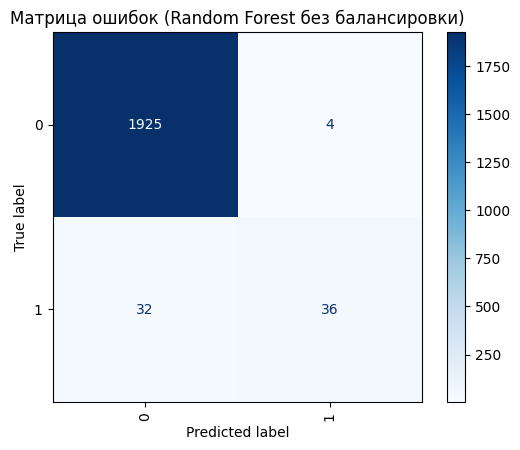

Отчёт по каждому классу:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1929
           1       0.90      0.53      0.67        68

    accuracy                           0.98      1997
   macro avg       0.94      0.76      0.83      1997
weighted avg       0.98      0.98      0.98      1997



In [35]:
print("Размер обучающей выборки:", X_train.shape)
print("Распределение классов:")
print(pd.Series(y_train).value_counts().sort_index())

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Матрица ошибок (Random Forest без балансировки)')
plt.show()

print("Отчёт по каждому классу:")
print(classification_report(y_test, y_pred, target_names=['0', '1'], zero_division=0))

# acc = accuracy_score(y_test, y_pred)
# prec_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
# rec_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
# f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

# bin_metrics_dict = {
#     'Метод': 'Бин. без балансировки',
#     'Accuracy': acc,
#     'Precision (macro)': prec_macro,
#     'Recall (macro)': rec_macro,
#     'F1-score (macro)': f1_macro
# }

# metrics_binary.append(bin_metrics_dict)

1. 0 (1925 верно, 4 ошибки)
2. 1 (36 верно, 32 ошибок)

Модель без балансировки в бинарной постановке демонстрирует высокую общую точность (98%), но за счёт почти идеального распознавания доминирующего класса «No Failure» (0): из 1929 нормальных случаев ошибочно помечены как отказы лишь 4. В то же время способность обнаруживать реальные отказы (класс 1) остаётся ограниченной: из 68 истинных отказов модель находит только 32, то есть пропускает почти половину аварийных ситуаций (recall = 0.53).

Хотя точность для класса «отказ» достаточно высока (0.90) — то есть ложные тревоги редки, — низкий recall делает систему ненадёжной в практическом применении, где критически важно не упустить реальный отказ. Это типичное поведение модели на несбалансированных данных: она минимизирует общую ошибку, предпочитая «перестраховаться» в сторону доминирующего класса.

Высокие значения weighted-усреднённых метрик и accuracy вновь маскируют эту проблему, тогда как macro-усреднённый recall (0.76) и, особенно, F1 для класса 1 (0.67) честно отражают слабость модели в обнаружении отказов.

### b. Undersampling

Размер train ДО undersampling: (7985, 8)
Распределение ДО:
Target
0    7714
1     271
Name: count, dtype: int64

Размер train ПОСЛЕ undersampling: (542, 8)
Распределение ПОСЛЕ:
Target
0    271
1    271
Name: count, dtype: int64


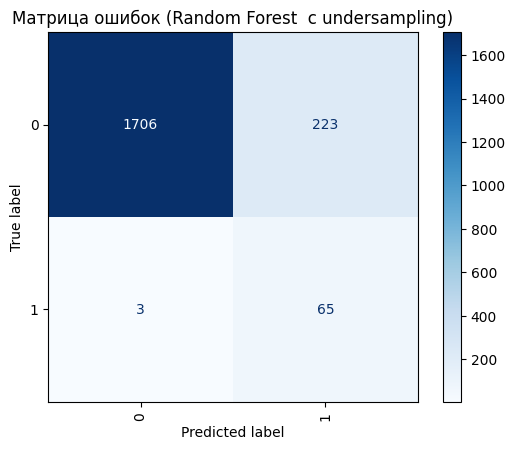

Отчёт по каждому классу:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      1929
           1       0.23      0.96      0.37        68

    accuracy                           0.89      1997
   macro avg       0.61      0.92      0.65      1997
weighted avg       0.97      0.89      0.92      1997



In [36]:
print("Размер train ДО undersampling:", X_train.shape)
print("Распределение ДО:")
print(pd.Series(y_train).value_counts().sort_index())

undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

print("\nРазмер train ПОСЛЕ undersampling:", X_train_under.shape)
print("Распределение ПОСЛЕ:")
print(pd.Series(y_train_under).value_counts().sort_index())

model_under = RandomForestClassifier(n_estimators=100, random_state=42)
model_under.fit(X_train_under, y_train_under)

y_pred_under = model_under.predict(X_test)

cm_under = confusion_matrix(y_test, y_pred_under)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_under, display_labels=['0', '1'])
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Матрица ошибок (Random Forest  с undersampling)')
plt.show()

print("Отчёт по каждому классу:")
print(classification_report(y_test, y_pred_under, target_names=['0', '1'], zero_division=0))

acc = accuracy_score(y_test, y_pred_under)
prec_macro = precision_score(y_test, y_pred_under, average='macro', zero_division=0)
rec_macro = recall_score(y_test, y_pred_under, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred_under, average='macro', zero_division=0)

bin_metrics_under = {
    'Метод': 'Бин. undersampling',
    'Accuracy': acc,
    'Precision (macro)': prec_macro,
    'Recall (macro)': rec_macro,
    'F1-score (macro)': f1_macro
}

metrics_binary.append(bin_metrics_under)

1. 0 (1706 верно, 223 ошибки)
2. 1 (65 верно, 3 ошибок)

После применения undersampling модель демонстрирует полярное, но проблемное поведение: она теперь почти никогда не пропускает отказы — recall для класса 1 достигает 96%, то есть из 68 реальных аварий обнаружено 65. Однако эта сверхчувствительность достигается за счёт массовых ложных срабатываний: из всех случаев, когда модель предсказала «отказ», лишь 23% оказались верными, а 1706 нормальных ситуаций (из 1929) были ошибочно классифицированы как поломки. Общая точность упала до 89%, что отражает рост ошибок, а макро-F1 (0.65) остаётся низким из-за крайне низкой precision по классу отказа. 

### c. Oversampling

Размер train ДО oversampling: (7985, 8)
Распределение ДО:
Target
0    7714
1     271
Name: count, dtype: int64

Размер train ПОСЛЕ oversampling: (15428, 8)
Распределение ПОСЛЕ:
Target
0    7714
1    7714
Name: count, dtype: int64


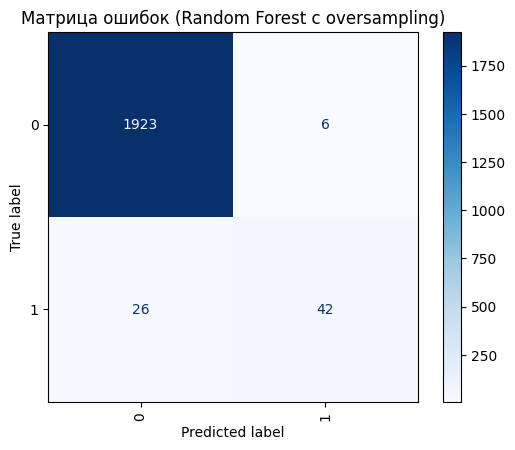

Отчёт по каждому классу:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1929
           1       0.88      0.62      0.72        68

    accuracy                           0.98      1997
   macro avg       0.93      0.81      0.86      1997
weighted avg       0.98      0.98      0.98      1997



In [37]:
print("Размер train ДО oversampling:", X_train.shape)
print("Распределение ДО:")
print(pd.Series(y_train).value_counts().sort_index())

oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

print("\nРазмер train ПОСЛЕ oversampling:", X_train_over.shape)
print("Распределение ПОСЛЕ:")
print(pd.Series(y_train_over).value_counts().sort_index())

model_over = RandomForestClassifier(n_estimators=100, random_state=42)
model_over.fit(X_train_over, y_train_over)

y_pred_over = model_over.predict(X_test)

cm_over = confusion_matrix(y_test, y_pred_over)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_over, display_labels=['0', '1'])
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Матрица ошибок (Random Forest с oversampling)')
plt.show()

print("Отчёт по каждому классу:")
print(classification_report(y_test, y_pred_over, target_names=['0', '1'], zero_division=0))

acc = accuracy_score(y_test, y_pred_over)
prec_macro = precision_score(y_test, y_pred_over, average='macro', zero_division=0)
rec_macro = recall_score(y_test, y_pred_over, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred_over, average='macro', zero_division=0)

bin_metrics_over = {
    'Метод': 'Бин. oversampling',
    'Accuracy': acc,
    'Precision (macro)': prec_macro,
    'Recall (macro)': rec_macro,
    'F1-score (macro)': f1_macro,
}

metrics_binary.append(bin_metrics_over)

1. 0 (1923 верно, 6 ошибки)
2. 1 (42 верно, 26 ошибок)

Модель сохраняет почти идеальную способность распознавать нормальную работу оборудования — из 1929 случаев «0» лишь 6 ошибочно классифицированы как отказы (precision = 0.99, recall = 1.00). При этом модель существенно улучшила обнаружение реальных отказов: из 68 аварийных ситуаций выявлено 26, что даёт recall = 0.62 — заметный рост по сравнению с базовой моделью без балансировки (0.53).

Ещё важнее, что precision для класса «отказ» достигла 0.88, то есть из всех случаев, когда модель предсказывает поломку, 88% действительно являются отказами. Высокие значения macro-усреднённых метрик (recall = 0.81, F1 = 0.86) подтверждают, что баланс между классами достигнут гораздо лучше: модель не жертвует одним классом ради другого.

## d. SMOTE

Размер обучающей выборки ДО SMOTE: (7985, 8)
Распределение классов ДО SMOTE:
Target
0    7714
1     271
Name: count, dtype: int64

Размер обучающей выборки ПОСЛЕ SMOTE: (15428, 8)
Распределение классов ПОСЛЕ SMOTE:
Target
0    7714
1    7714
Name: count, dtype: int64


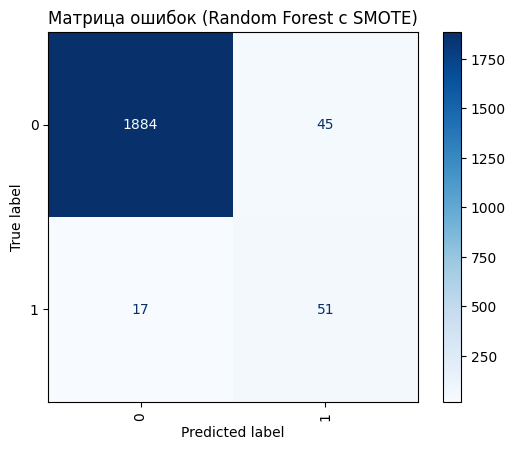

Отчёт по каждому классу:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1929
           1       0.53      0.75      0.62        68

    accuracy                           0.97      1997
   macro avg       0.76      0.86      0.80      1997
weighted avg       0.98      0.97      0.97      1997



In [38]:
print("Размер обучающей выборки ДО SMOTE:", X_train.shape)
print("Распределение классов ДО SMOTE:")
print(pd.Series(y_train).value_counts().sort_index())

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nРазмер обучающей выборки ПОСЛЕ SMOTE:", X_train_smote.shape)
print("Распределение классов ПОСЛЕ SMOTE:")
print(pd.Series(y_train_smote).value_counts().sort_index())

model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = model_smote.predict(X_test)

cm_smote = confusion_matrix(y_test, y_pred_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=['0', '1'])
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Матрица ошибок (Random Forest с SMOTE)')
plt.show()

print("Отчёт по каждому классу:")
print(classification_report(y_test, y_pred_smote, target_names=['0', '1'], zero_division=0))

acc = accuracy_score(y_test, y_pred_smote)
prec_macro = precision_score(y_test, y_pred_smote, average='macro', zero_division=0)
rec_macro = recall_score(y_test, y_pred_smote, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred_smote, average='macro', zero_division=0)

bin_metrics_smote = {
    'Метод': 'Бин. smote',
    'Accuracy': acc,
    'Precision (macro)': prec_macro,
    'Recall (macro)': rec_macro,
    'F1-score (macro)': f1_macro
}

metrics_binary.append(bin_metrics_smote)

1. 0 (1884 верно, 45 ошибки)
2. 1 (51 верно, 17 ошибок)

Модель, обученная с применением SMOTE, демонстрирует сильную способность обнаруживать отказы: из 68 реальных аварийных случаев она выявила 51, что соответствует recall = 0.75 — один из лучших результатов среди всех протестированных методов. Это означает, что система пропускает лишь четверть реальных поломок, что значительно лучше, чем в базовой модели без балансировки.

Однако эта высокая чувствительность достигается за счёт снижения точности по классу отказа: precision = 0.53 означает, что почти половина всех предсказанных отказов — ложные тревоги. Действительно, модель ошибочно пометила как отказы 45 нормальных случаев из 1929, что может привести к избыточным проверкам и простою оборудования в реальной эксплуатации.

Тем не менее, модель сохраняет высокую надёжность в распознавании нормы: 98% случаев «No Failure» определены верно, а F1-score для положительного класса (0.62) остаётся приемлемым. Macro-усреднённый recall (0.86) подтверждает, что SMOTE эффективно улучшает обнаружение редкого класса, но ценой роста ложных срабатываний.

### Результаты

Сравнительная таблица моделей (отсортировано по F1-score (macro)):

             Метод Accuracy Precision (macro) Recall (macro) F1-score (macro)
Бин. undersampling    0.887             0.612          0.920            0.652
 Бин. oversampling    0.984             0.931          0.807            0.858
        Бин. smote    0.969             0.761          0.863            0.803


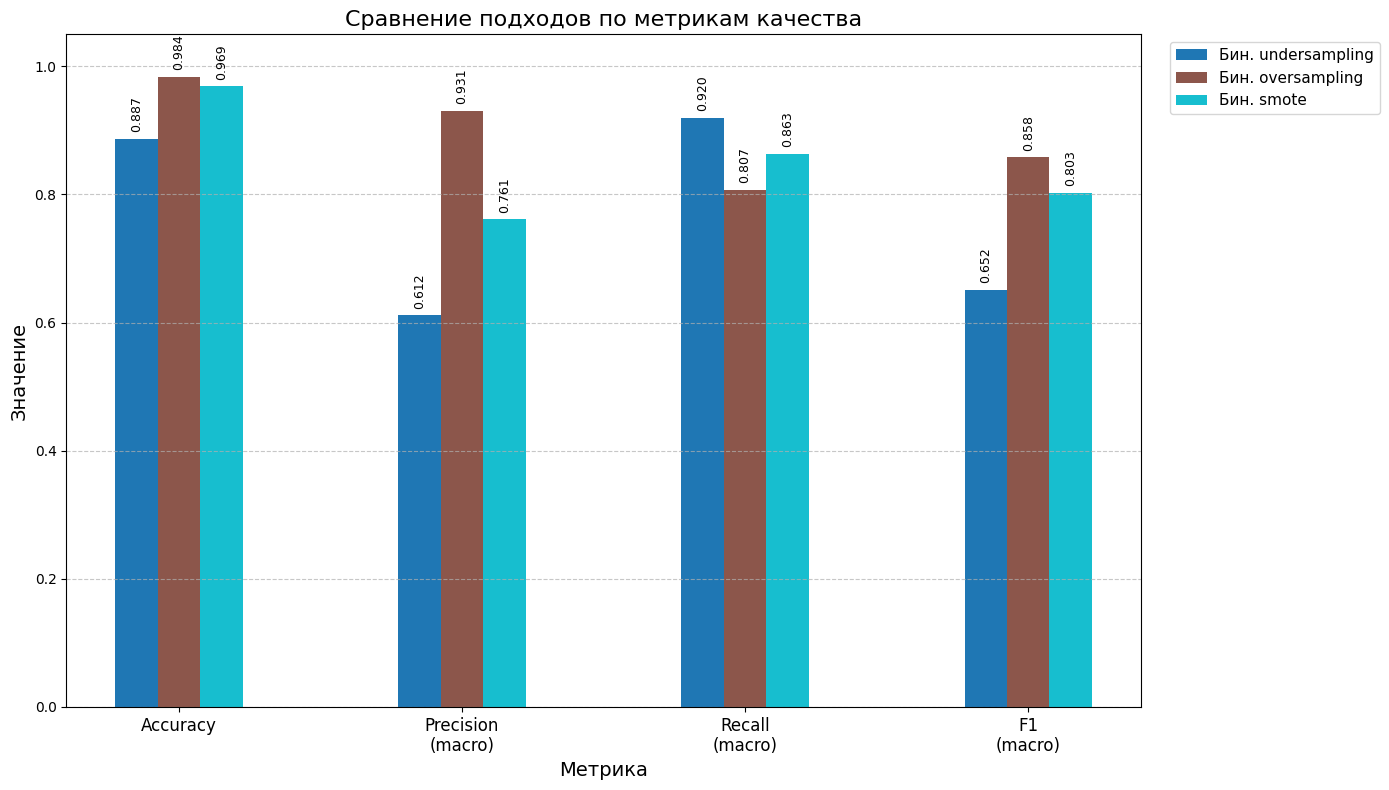

In [ ]:
df_results = pd.DataFrame(metrics_binary)

print("Сравнительная таблица моделей (отсортировано по F1-score (macro)):\n")

formatted_df = df_results.copy()
for col in ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-score (macro)', 'F1-score (weighted)']:
    if col in formatted_df.columns:
        formatted_df[col] = formatted_df[col].apply(lambda x: f'{x:.3f}')

print(formatted_df.to_string(index=False))

df_plot = df_results.set_index('Метод')[
    ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-score (macro)']
]

models = df_plot.index.tolist()
metrics = df_plot.columns.tolist()
n_models = len(models)
n_metrics = len(metrics)

bar_width = 0.15
index = np.arange(n_metrics)
colors = plt.cm.tab10(np.linspace(0, 1, n_models))

plt.figure(figsize=(14, 8))

for i, model in enumerate(models):
    values = df_plot.loc[model].values
    plt.bar(index + i * bar_width, values, bar_width, label=model, color=colors[i])

plt.xlabel('Метрика', fontsize=14)
plt.ylabel('Значение', fontsize=14)
plt.title('Сравнение подходов по метрикам качества', fontsize=16)
plt.xticks(index + bar_width * (n_models - 1) / 2, 
           ['Accuracy', 'Precision\n(macro)', 'Recall\n(macro)', 'F1\n(macro)'],
           fontsize=12)
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, model in enumerate(models):
    for j, value in enumerate(df_plot.loc[model].values):
        plt.text(j + i * bar_width, value + 0.01, f'{value:.3f}',
                 ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()


На основе сравнительной таблицы результатов бинарной классификации, отсортированной по F1-score (macro) — метрике, которая одинаково учитывает оба класса и является стандартом для задач с дисбалансом, — лучшим методом балансировки является oversampling.

Он достигает наивысшего значения F1-score (macro) = 0.858, что указывает на наилучший баланс между точностью и полнотой по обоим классам одновременно. При этом он превосходит как исходную модель без балансировки (0.829), так и более сложные методы: SMOTE (0.803) и undersampling (0.652).

Хотя SMOTE показывает максимальный recall (0.863), его низкая precision (0.761) снижает общую гармоническую меру. Undersampling, в свою очередь, даёт крайне низкую precision (0.612), что недопустимо с точки зрения сбалансированной оценки. Модель без балансировки уступает по F1, несмотря на высокую точность, из-за недостаточного recall.

Таким образом, по главной метрике сравнения — F1-score (macro) — oversampling демонстрирует наилучшее качество классификации и признаётся лучшим методом балансировки среди рассмотренных.

## Заключение

Обобщая результаты работы, можно заключить, что выбор лучшего метода балансировки зависит от постановки задачи — в частности, от того, решается ли многоклассовая или бинарная задача классификации.

В многоклассовой постановке, где модель должна не только обнаружить отказ, но и точно определить его тип, наилучшим методом оказался SMOTE. Он продемонстрировал максимальный F1-score (macro) = 0.688, показав способность одновременно находить редкие отказы и сохранять разумную точность предсказаний. Это особенно важно, когда каждый тип поломки требует отдельного реагирования, и ошибки как на редких, так и на частых классах критичны.

В бинарной постановке, где задача упрощена до распознавания только самого факта отказа («есть/нет»), лидирующим методом стал oversampling с F1-score (macro) = 0.858. В этом случае простое дублирование редких примеров оказалось более эффективным, чем генерация синтетических данных: модель достигла лучшего баланса между полнотой и точностью, избегая как пропуска отказов, так и избыточных ложных тревог.

Таким образом, нет универсального «лучшего» метода балансировки — его эффективность определяется структурой задачи. SMOTE лучше справляется с сложностью многоклассового разграничения, в то время как oversampling оказывается предпочтительнее в более простой и фокусированной бинарной задаче. Это подчёркивает важность адаптации методов препроцессинга под конкретную цель моделирования, даже в рамках одной и той же предметной области.